### Загрузим и обработаем датасет

In [ ]:
from  load_data import Load_Process_Dataset

D = Load_Process_Dataset('adult')
D.start_load()

### train VAE


#### params

In [2]:
LR = 1e-3
WD = 0
D_TOKEN = 4
TOKEN_BIAS = True

In [3]:
N_HEAD = 1
FACTOR = 32
NUM_LAYERS = 2

In [4]:
import torch
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cuda


In [5]:
from model_train.train_vae import VAE_main

vae_train = VAE_main(name = 'adult', LR = 1e-3, WD = 0, D_TOKEN = 4, N_HEAD = 1, FACTOR = 32, NUM_LAYERS = 2)

In [ ]:
vae_train.tabsyn_vae_main(device = my_device, num_epochs = 4000)

###train TabSyn

In [ ]:
from model_train.train_tabsyn import tabsyn_main
tabsyn_main(my_device, 'adult', 10000)

###Генерируем синтетику

In [ ]:
from generate_synthetic import sample_main
sample_main()

### Сравнение на классификаторе

In [ ]:
pip install prdc

In [10]:
from metrics.mle import MLE

Синтетика

In [ ]:
dataname = 'adult'

train_path = f'synthetic/{dataname}/synthetic.csv'
test_path = f'synthetic/{dataname}/test.csv'
MLE(train_path, test_path, dataname, model = 'synt')

Трушные

In [ ]:
dataname = 'adult'
model = 'real'
train_path = f'synthetic/{dataname}/{model}.csv'
test_path = f'synthetic/{dataname}/test.csv'

MLE(train_path, test_path, dataname, model = 'real')

In [13]:
import json
import pandas as pd
with open('/content/eval/mle/adult/synt.json', 'r') as myFile:
    synthetic = json.load(myFile)

In [14]:
with open('/content/eval/mle/adult/real.json', 'r') as myFile:
    real = json.load(myFile)

In [15]:
df_real = pd.DataFrame({key: value["XGBClassifier"] for key, value in real.items()})
df_synt = pd.DataFrame({key: value["XGBClassifier"] for key, value in synthetic.items()})

df_real = df_real.rename(index={key: f'{key}_real' for key in df_real.index})
df_synt = df_synt.rename(index={key: f'{key}_synt' for key in df_synt.index})

df = pd.concat([df_real, df_synt])
df.sort_index(inplace=True)

df

,best_f1_scores,best_weighted_scores,best_auroc_scores,best_acc_scores,best_avg_scores
accuracy_real,0.873165,0.873165,0.873349,0.873165,0.873165
accuracy_synt,0.857994,0.857994,0.858178,0.857994,0.857994
binary_f1_real,0.707466,0.707466,0.709823,0.707466,0.707466
binary_f1_synt,0.669431,0.669431,0.670660,0.669431,0.669431
roc_auc_real,0.926622,0.926622,0.927908,0.926622,0.926622
roc_auc_synt,0.910118,0.910118,0.910960,0.910118,0.910118
weighted_f1_real,0.757443,0.757443,0.759235,0.757443,0.757443
weighted_f1_synt,0.726159,0.726159,0.727112,0.726159,0.726159


### Alpha Precision and Beta Recall

In [ ]:
pip install synthcity

In [1]:
from metrics.alpha_beta import Alpha_Beta
Alpha_Beta()

=========== All Features ===========
Data shape:  (32561, 110)
alpha precision: 0.994465, beta recall: 0.476525


### Density estimation of single column and pair-wise correlation

In [ ]:
pip install sdmetrics

In [5]:
import numpy as np
import pandas as pd
import os

import json

# Metrics
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport


def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))


    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']


    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]


    return new_real_data, new_syn_data, metadata


In [6]:
dataname = 'adult'
model = 'model'

syn_path = 'synthetic/adult/synthetic.csv'

real_path = f'synthetic/{dataname}/real.csv'

data_dir = f'data/{dataname}'
print(syn_path)

with open(f'{data_dir}/info.json', 'r') as f:
    info = json.load(f)

syn_data = pd.read_csv(syn_path)
real_data = pd.read_csv(real_path)

save_dir = f'eval/density/{dataname}/{model}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

real_data.columns = range(len(real_data.columns))
syn_data.columns = range(len(syn_data.columns))

metadata = info['metadata']
metadata['columns'] = {int(key): value for key, value in metadata['columns'].items()}

new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

qual_report = QualityReport()
qual_report.generate(new_real_data, new_syn_data, metadata)

diag_report = DiagnosticReport()
diag_report.generate(new_real_data, new_syn_data, metadata)

quality =  qual_report.get_properties()
diag = diag_report.get_properties()

Shape = quality['Score'][0]
Trend = quality['Score'][1]

with open(f'{save_dir}/quality.txt', 'w') as f:
    f.write(f'{Shape}\n')
    f.write(f'{Trend}\n')

Quality = (Shape + Trend) / 2

# shapes = qual_report.get_details(property_name='Column Shapes')
# trends = qual_report.get_details(property_name='Column Pair Trends')
# coverages = diag_report.get_details('Coverage')


# shapes.to_csv(f'{save_dir}/shape.csv')
# trends.to_csv(f'{save_dir}/trend.csv')
# coverages.to_csv(f'{save_dir}/coverage.csv')

synthetic/adult/synthetic.csv
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 53.23it/s]|
Column Shapes Score: 99.32%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:02<00:00, 48.77it/s]|
Column Pair Trends Score: 98.28%

Overall Score (Average): 98.8%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 245.50it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 295.79it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [7]:
shapes = qual_report.get_details(property_name='Column Shapes')
trends = qual_report.get_details(property_name='Column Pair Trends')
coverages_srt = diag_report.get_details('Data Structure')
coverages_val = diag_report.get_details('Data Validity')

In [8]:
qual_report.get_properties()

,Property,Score
0,Column Shapes,0.993166
1,Column Pair Trends,0.982782


In [ ]:
# pip install kaleido

In [9]:
# pip install plotly==5.5.0

In [10]:
import kaleido
import plotly

kaleido.__version__, plotly.__version__

('0.2.1', '5.5.0')

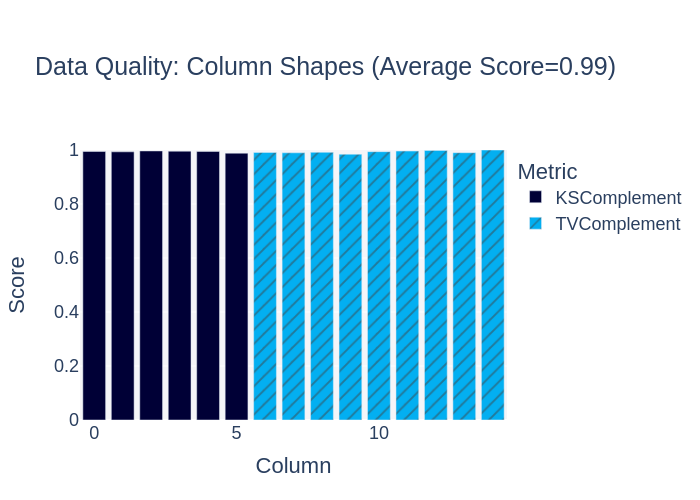

In [11]:
fig = qual_report.get_visualization(property_name='Column Shapes')
# fig.show()
fig.show(renderer = 'png')

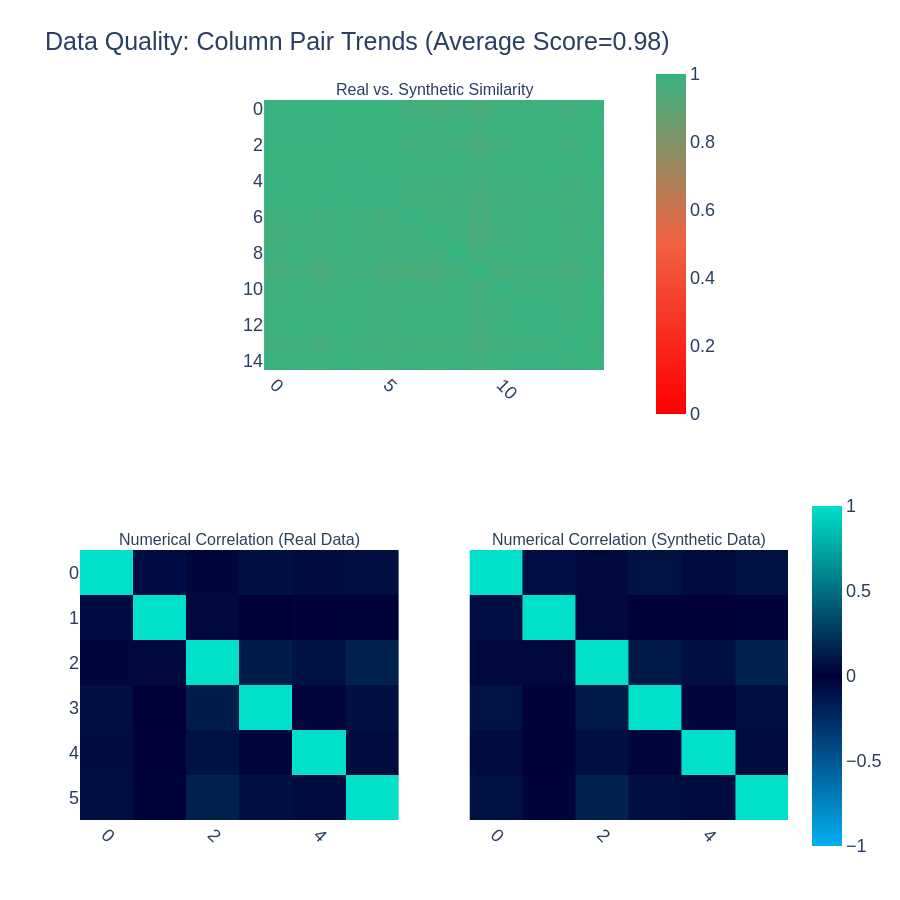

In [12]:
fig = qual_report.get_visualization(property_name='Column Pair Trends')
fig.show(renderer = 'png')

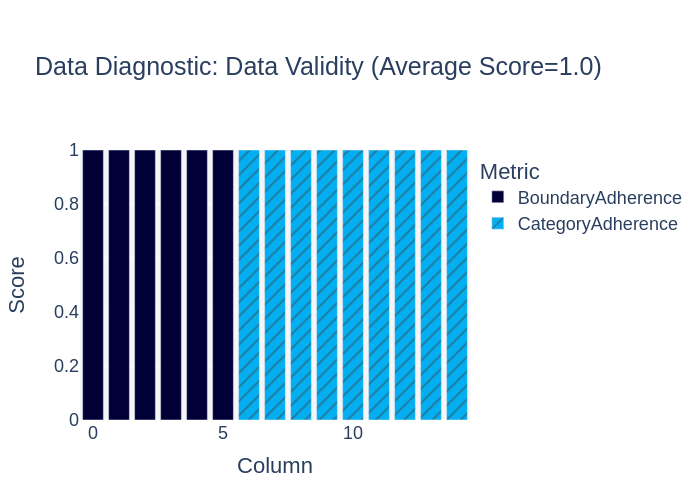

In [13]:
fig = diag_report.get_visualization(property_name = 'Data Validity')
fig.show(renderer = 'png')

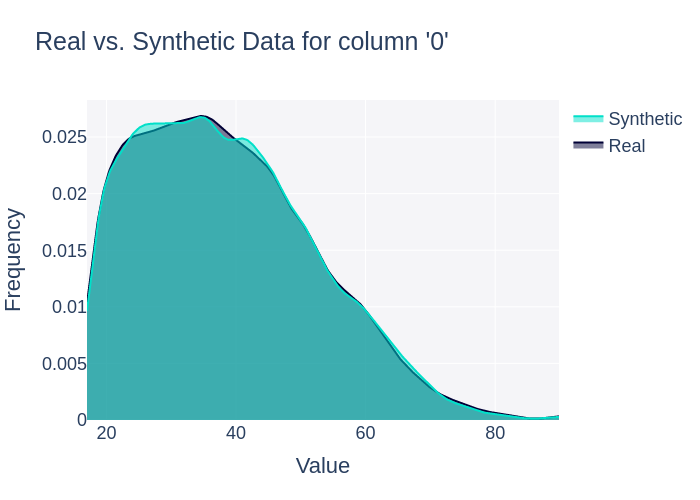

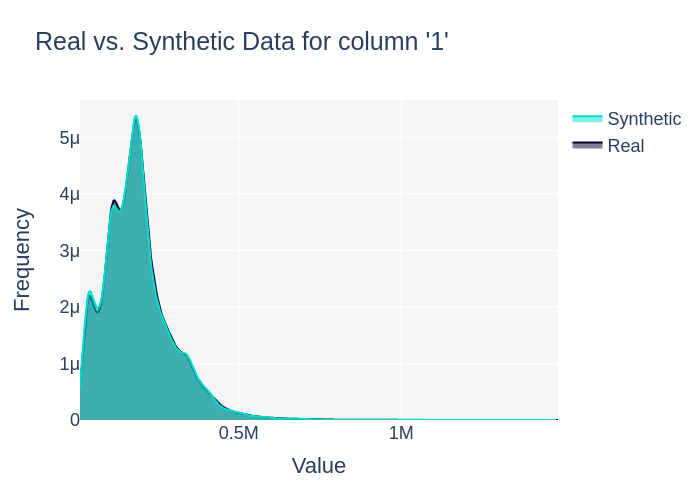

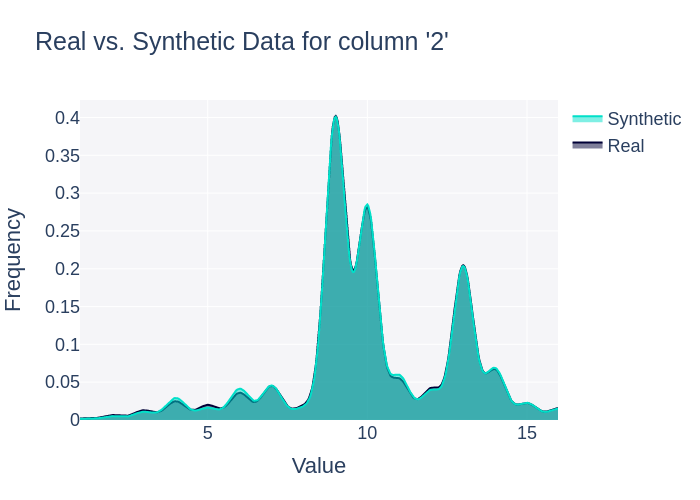

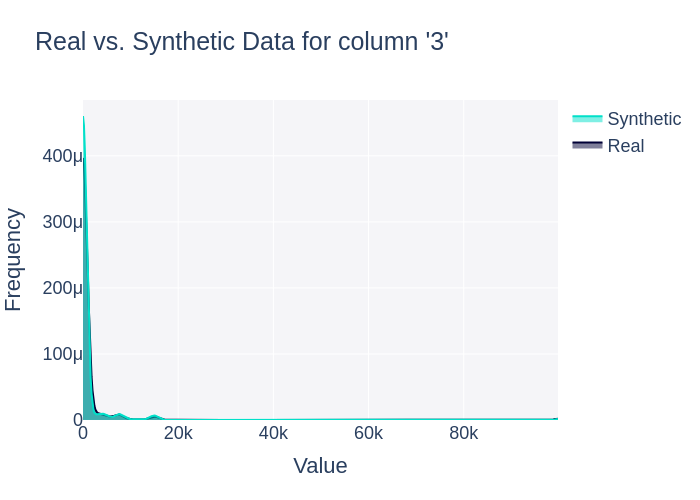

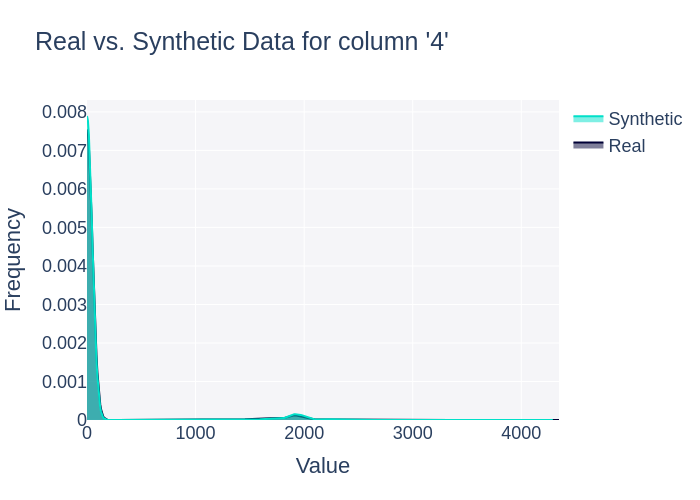

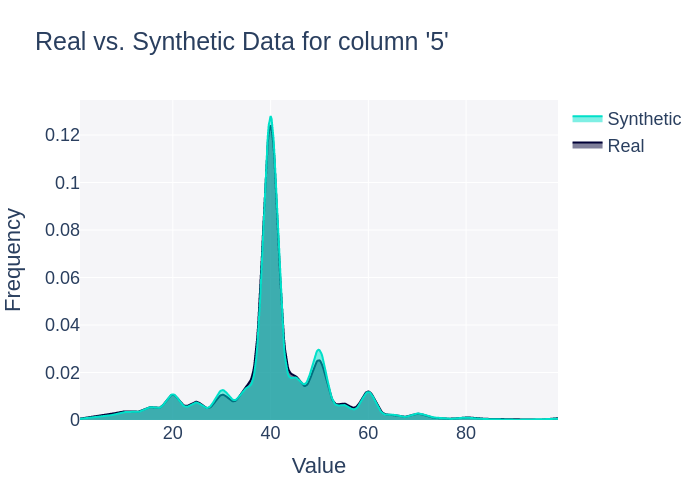

In [14]:
from sdmetrics.visualization import get_column_plot
for i in range(0, 6):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name= i,
        plot_type='distplot'
    )

    fig.show(renderer = 'png')

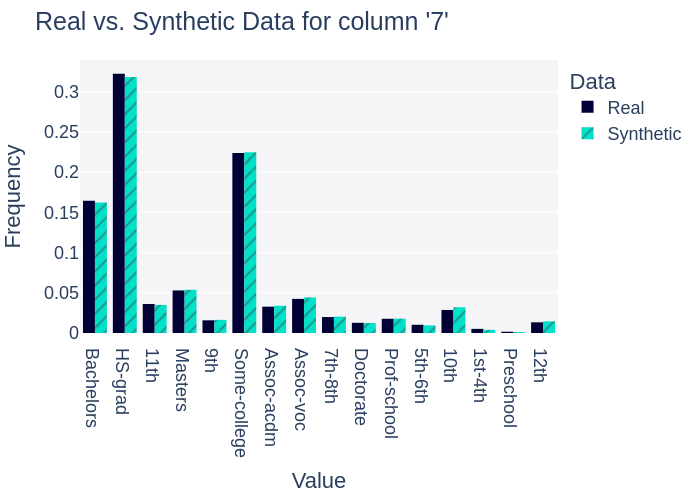

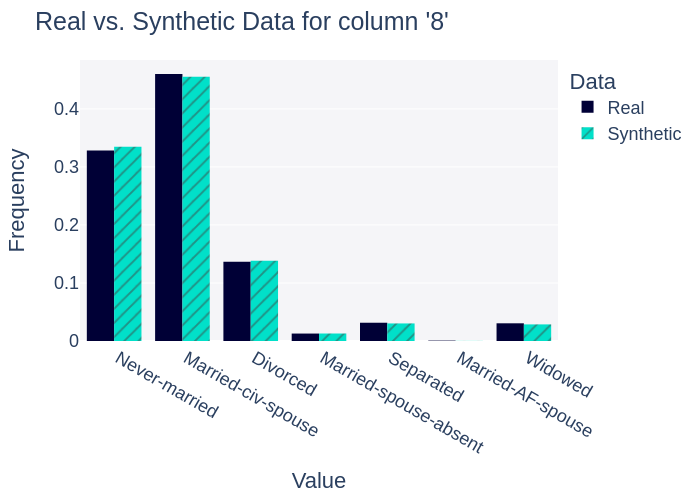

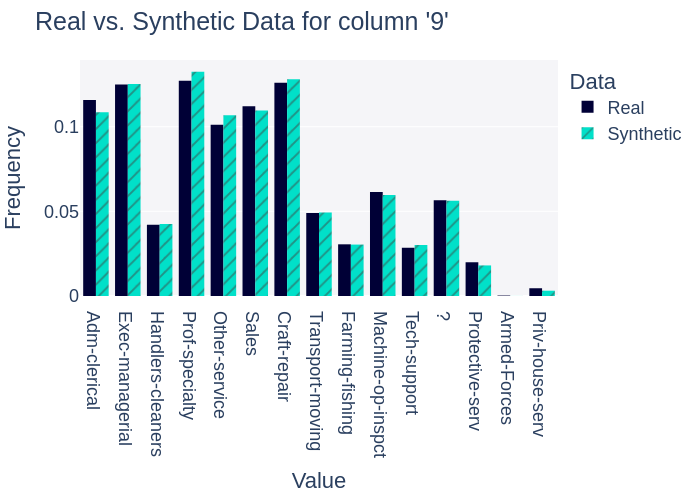

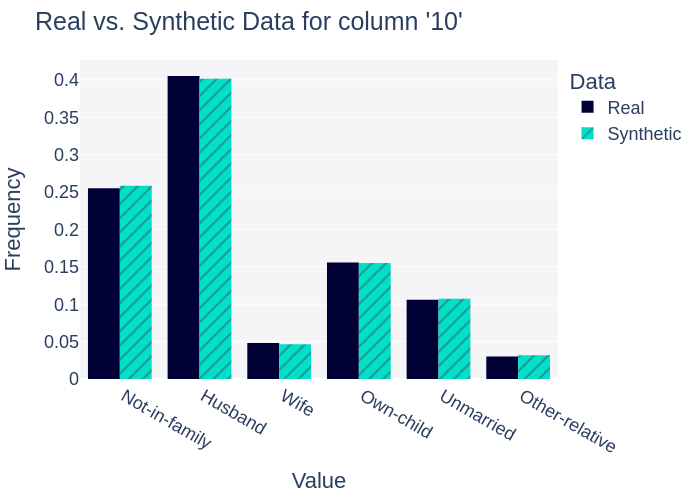

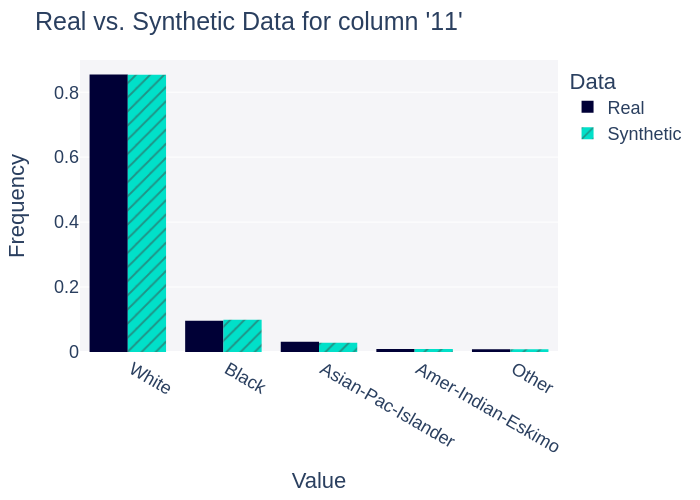

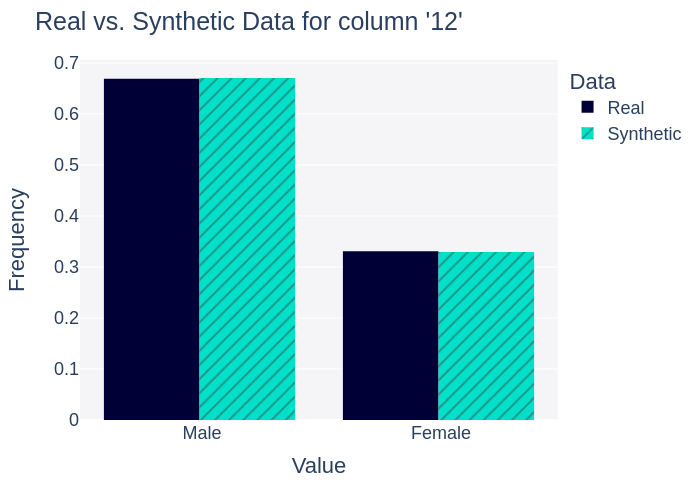

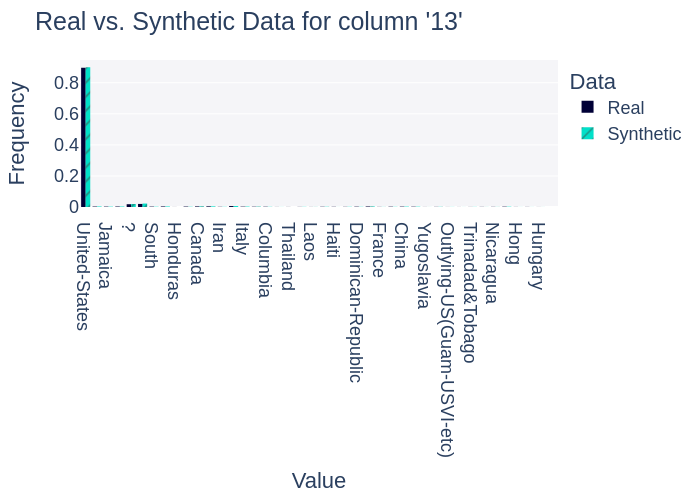

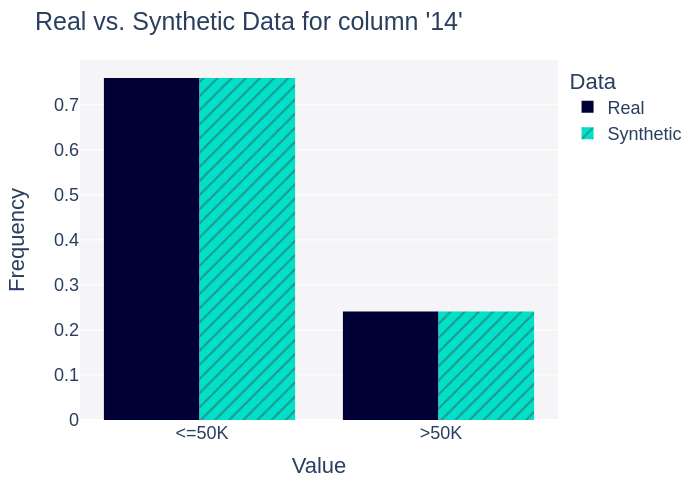

In [15]:
for i in range(7, 15):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name= i,
        plot_type='bar'
    )

    fig.show(renderer = 'png')

### Pricavy protection: Distance to Closest Record (DCR)

In [2]:
from metrics.dcr import DCR
DCR()

DCR Score, a value closer to 0.5 is better
adult-model, DCR Score = 0.6724916310924112


### Detection: Classifier Two Sample Tests (C2ST)

In [1]:
from metrics.c2st import Detection
Detection()

adult, model: 0.9933146300066799
